# Modeling Routes

In [66]:
# Setup and Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import json
from tqdm import tqdm
import warnings
import gc
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Set random seeds
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

print("✅ Setup complete")

Using device: cpu
✅ Setup complete


In [67]:
# Path Configuration
# Directory structure: root/data/raw, root/data/processed, root/data/splits

ROOT_PATH = Path("..")  # Adjust to ".." if in a subfolder
DATA_PATH = ROOT_PATH / "data"
RAW_DATA_PATH = DATA_PATH / "raw"
PROCESSED_DATA_PATH = DATA_PATH / "processed"
SPLITS_DATA_PATH = DATA_PATH / "splits"

# Create directories
PROCESSED_DATA_PATH.mkdir(exist_ok=True, parents=True)
SPLITS_DATA_PATH.mkdir(exist_ok=True, parents=True)

print("📁 Directory Structure:")
print(f"  RAW:  {RAW_DATA_PATH.absolute()}")
print(f"  PROCESSED: {PROCESSED_DATA_PATH.absolute()}")

📁 Directory Structure:
  RAW:  c:\Users\jrzem\Downloads\NFL-Big-Data-Bowl-2026-Analytics-Challenge\notebooks\..\data\raw
  PROCESSED: c:\Users\jrzem\Downloads\NFL-Big-Data-Bowl-2026-Analytics-Challenge\notebooks\..\data\processed


In [68]:
# Discover Available Data Files

print("🔍 Scanning for data files...")

# Check raw data
input_files = sorted(RAW_DATA_PATH.glob("input_2023_w*.csv"))
output_files = sorted(RAW_DATA_PATH.glob("output_2023_w*.csv"))

# Check processed data (The Parquet files)
parquet_files = sorted(PROCESSED_DATA_PATH.glob("features_enhanced_w*.parquet"))

print(f"\n📂 Raw Data ({RAW_DATA_PATH}):")
print(f"  Input files: {len(input_files)}")
print(f"  Output files: {len(output_files)}")

print(f"\n📂 Processed Data ({PROCESSED_DATA_PATH}):")
print(f"  Parquet files: {len(parquet_files)}")

if not parquet_files:
    print("⚠️ No parquet files found! Please run 02_features.py first.")
    # Fallback to raw files if needed
    available_weeks = [int(f.stem.split('_w')[-1]) for f in input_files]
else:
    # Extract weeks from parquet filenames
    available_weeks = []
    for f in parquet_files:
        try:
            week_str = f.stem.split('_w')[-1]
            available_weeks.append(int(week_str))
        except ValueError:
            pass

available_weeks = sorted(set(available_weeks))
print(f"\n📅 Available weeks: {available_weeks}")

🔍 Scanning for data files...

📂 Raw Data (..\data\raw):
  Input files: 18
  Output files: 18

📂 Processed Data (..\data\processed):
  Parquet files: 18

📅 Available weeks: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


In [69]:
# Define Train/Validation Split

# Use last 4 weeks for validation
if len(available_weeks) > 4:
    VAL_WEEKS = available_weeks[-4:]
    TRAIN_WEEKS = available_weeks[:-4]
else:
    split_idx = max(1, int(len(available_weeks) * 0.8))
    TRAIN_WEEKS = available_weeks[:split_idx]
    VAL_WEEKS = available_weeks[split_idx:]

print("📊 Train/Validation Split:")
print(f"  TRAIN_WEEKS: {TRAIN_WEEKS}")
print(f"  VAL_WEEKS: {VAL_WEEKS}")

📊 Train/Validation Split:
  TRAIN_WEEKS: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
  VAL_WEEKS: [15, 16, 17, 18]


In [70]:
# Parquet Dataset Class (Fixed Anchor Logic)

class NFLTrajectoryDatasetParquet(Dataset):
    def __init__(
        self,
        weeks,
        processed_data_path,
        raw_data_path,
        max_input_frames=24,
        max_output_frames=20,
        max_players=16,
        normalize=True,
        augment=False,
        means=None,
        stds=None
    ):
        self.weeks = weeks
        self.processed_data_path = Path(processed_data_path)
        self.raw_data_path = Path(raw_data_path)
        self.max_input_frames = max_input_frames
        self.max_output_frames = max_output_frames
        self.max_players = max_players
        self.normalize = normalize
        self.augment = augment
        
        self.feature_cols = [
            'x', 'y', 's', 'a', 
            's_smooth', 'a_smooth', 'jerk', 'dir_change',
            'dist_to_qb', 'dist_to_target', 'dist_to_nearest_sideline',
            'receiver_separation', 'nearest_opponent_dist',
            'score_differential', 'yards_to_go'
        ]
        
        self.meta_cols = ['game_id', 'play_id', 'frame_id', 'nfl_id', 
                          'player_role', 'player_side', 'player_to_predict', 
                          'dir', 'o', 'num_frames_output']
        
        print(f"\n📂 Initializing PARQUET dataset for weeks: {weeks}")
        self.data = self._load_data()
        self.play_ids = self.data[['week', 'game_id', 'play_id']].drop_duplicates().values
        self.play_indices = self.data.groupby(['game_id', 'play_id']).indices
        
        if self.normalize:
            if means is not None:
                self.means = means
                self.stds = stds
            else:
                self._compute_stats()
            
        self.role_map = {"Passer": 0, "Targeted Receiver": 1, "Other Route Runner": 2, "Defensive Coverage": 3}
        self.side_map = {"Offense": 0, "Defense": 1}
        print(f"✅ Loaded {len(self.play_ids):,} plays")

    def _load_data(self):
        data_frames = []
        cols_to_load = list(set(self.feature_cols + self.meta_cols))
        for week in self.weeks:
            path = self.processed_data_path / f"features_enhanced_w{week:02d}.parquet"
            if path.exists():
                df = pd.read_parquet(path, columns=cols_to_load)
                df['week'] = week
                fcols = df.select_dtypes(include=['float64']).columns
                df[fcols] = df[fcols].astype(np.float32)
                df = df.fillna(0)
                data_frames.append(df)
        return pd.concat(data_frames, ignore_index=True) if data_frames else pd.DataFrame()

    def _compute_stats(self):
        self.means = self.data[self.feature_cols].mean().values.astype(np.float32)
        self.stds = self.data[self.feature_cols].std().values.astype(np.float32)
        self.stds[self.stds == 0] = 1.0
        self.means = np.concatenate([self.means, np.zeros(4)])
        self.stds = np.concatenate([self.stds, np.ones(4)])

    def __len__(self):
        return len(self.play_ids)

    def __getitem__(self, idx):
        week, game_id, play_id = self.play_ids[idx]
        indices = self.play_indices[(game_id, play_id)]
        play_df = self.data.iloc[indices].copy()
        
        output_file = self.raw_data_path / f"output_2023_w{int(week):02d}.csv"
        output_df = pd.read_csv(output_file)
        play_output = output_df[(output_df['game_id'] == game_id) & (output_df['play_id'] == play_id)]
        
        frames = sorted(play_df['frame_id'].unique())
        players = play_df['nfl_id'].unique()
        
        T, P = self.max_input_frames, self.max_players
        F_dim = len(self.feature_cols) + 4
        T_out = self.max_output_frames
        
        X = np.zeros((T, P, F_dim), dtype=np.float32)
        Y = np.zeros((P, T_out, 2), dtype=np.float32)
        mask = np.ones((T, P), dtype=bool)
        role_ids = np.zeros(P, dtype=np.int64)
        side_ids = np.zeros(P, dtype=np.int64)
        players_to_predict = np.zeros(P, dtype=bool)
        
        # Track last known position for anchor
        last_known_pos = np.zeros((P, 2), dtype=np.float32)
        
        num_out = int(play_df['num_frames_output'].iloc[0]) if 'num_frames_output' in play_df else 10
        num_out = min(num_out, T_out)
        player_to_idx = {p: i for i, p in enumerate(players[:P])}
        
        play_df['sin_dir'] = np.sin(np.radians(play_df['dir']))
        play_df['cos_dir'] = np.cos(np.radians(play_df['dir']))
        play_df['sin_o'] = np.sin(np.radians(play_df['o']))
        play_df['cos_o'] = np.cos(np.radians(play_df['o']))
        all_cols = self.feature_cols + ['sin_dir', 'cos_dir', 'sin_o', 'cos_o']
        
        play_df_indexed = play_df.set_index(['frame_id', 'nfl_id'])
        
        for fi, frame in enumerate(frames[:T]):
            for pid, pi in player_to_idx.items():
                if (frame, pid) in play_df_indexed.index:
                    row = play_df_indexed.loc[(frame, pid)]
                    X[fi, pi, :] = row[all_cols].values
                    mask[fi, pi] = False
                    
                    # Update anchor to current position
                    last_known_pos[pi, 0] = row['x']
                    last_known_pos[pi, 1] = row['y']
                    
                    if fi == 0:
                        role_ids[pi] = self.role_map.get(row['player_role'], 3)
                        side_ids[pi] = self.side_map.get(row['player_side'], 1)
                        players_to_predict[pi] = bool(row['player_to_predict'])

        # --- FIXED ANCHOR LOGIC ---
        anchors = last_known_pos # Now contains the last VALID position
        
        # Fill Y (Raw)
        for _, row in play_output.iterrows():
            pid = row['nfl_id']
            if pid in player_to_idx:
                pi = player_to_idx[pid]
                fi = int(row['frame_id']) - 1
                if 0 <= fi < T_out:
                    Y[pi, fi, 0] = row['x']
                    Y[pi, fi, 1] = row['y']
        
        # Make Y Relative
        for p in range(P):
            if players_to_predict[p]:
                Y[p, :, 0] -= anchors[p, 0]
                Y[p, :, 1] -= anchors[p, 1]

        if self.normalize:
            X = (X - self.means) / (self.stds + 1e-8)
            
        return {
            'input_seq': torch.from_numpy(X),
            'output_seq': torch.from_numpy(Y),
            'anchors': torch.from_numpy(anchors),
            'mask': torch.from_numpy(mask),
            'role_ids': torch.from_numpy(role_ids),
            'side_ids': torch.from_numpy(side_ids),
            'players_to_predict': torch.from_numpy(players_to_predict),
            'num_output_frames': num_out,
            'metadata': {'week': week, 'game_id': game_id, 'play_id': play_id}
        }

In [71]:
# Transformer Model (Lite version)

class TrajectoryTransformerLite(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_heads=4, num_layers=3, 
                 max_players=22, max_seq_len=30, max_output_frames=25, dropout=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.max_output_frames = max_output_frames
        
        self.input_projection = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout)
        )
        
        self.register_buffer('pos_encoding', self._generate_positional_encoding(max_seq_len, hidden_dim))
        self.role_embedding = nn.Embedding(5, hidden_dim)
        self.side_embedding = nn.Embedding(2, hidden_dim)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=num_heads, dim_feedforward=hidden_dim * 2,
            dropout=dropout, activation='gelu', batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.output_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, max_output_frames * 2)
        )
    
    def _generate_positional_encoding(self, max_len, d_model):
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        return pe
    
    def forward(self, x, role_ids, side_ids, num_output_frames, mask=None):
        B, T, P, F = x.shape
        x = x.permute(0, 2, 1, 3).reshape(B * P, T, F)
        x = self.input_projection(x)
        x = x + self.pos_encoding[:, :T, :]
        x = x + self.role_embedding(role_ids).reshape(B * P, 1, self.hidden_dim)
        x = x + self.side_embedding(side_ids).reshape(B * P, 1, self.hidden_dim)
        
        if mask is not None:
            mask = mask.permute(0, 2, 1).reshape(B * P, T)
        
        encoded = self.transformer(x, src_key_padding_mask=mask)
        output = self.output_head(encoded[:, -1, :])
        return output.reshape(B, P, self.max_output_frames, 2)

print("✅ Model class defined")

✅ Model class defined


In [72]:
# Create Datasets (Correct Normalization Transfer)

def collate_fn(batch):
    out = {}
    for key in batch[0].keys():
        if key in ['metadata', 'num_output_frames']:
            out[key] = [sample[key] for sample in batch]
        else:
            out[key] = torch.stack([sample[key] for sample in batch])
    return out

print("Creating training dataset...")
train_dataset = NFLTrajectoryDatasetParquet(
    weeks=TRAIN_WEEKS,
    processed_data_path=PROCESSED_DATA_PATH,
    raw_data_path=RAW_DATA_PATH,
    normalize=True,
    augment=True,
)

print("\nCreating validation dataset...")
# CRITICAL FIX: Pass training stats to validation dataset
val_dataset = NFLTrajectoryDatasetParquet(
    weeks=VAL_WEEKS,
    processed_data_path=PROCESSED_DATA_PATH,
    raw_data_path=RAW_DATA_PATH,
    normalize=True,
    augment=False,
    means=train_dataset.means,  # <--- Using Train Stats
    stds=train_dataset.stds     # <--- Using Train Stats
)

print(f"🚀 Training on {len(train_dataset)} plays")
print(f"🧐 Validating on {len(val_dataset)} plays")

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=0)

Creating training dataset...

📂 Initializing PARQUET dataset for weeks: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
✅ Loaded 10,862 plays

Creating validation dataset...

📂 Initializing PARQUET dataset for weeks: [15, 16, 17, 18]
✅ Loaded 3,246 plays
🚀 Training on 10862 plays
🧐 Validating on 3246 plays


In [73]:
# Test Data Loading
print("🧪 Testing data loading...")
try:
    batch = next(iter(train_loader))
    print("✅ Batch loaded successfully!")
    print(f"  Input shape: {batch['input_seq'].shape}")
    print(f"  Target shape: {batch['output_seq'].shape}")
except Exception as e:
    print(f"❌ Error: {e}")

🧪 Testing data loading...
✅ Batch loaded successfully!
  Input shape: torch.Size([32, 24, 16, 19])
  Target shape: torch.Size([32, 16, 20, 2])


In [74]:
# Training Functions (Fixed Dtype)
def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    num_batches = 0
    pbar = tqdm(loader, desc="Training")
    
    for batch in pbar:
        # FORCE FLOAT32 CASTING HERE
        input_seq = batch['input_seq'].to(device).float()  # <--- Added .float()
        output_seq = batch['output_seq'].to(device).float() # <--- Added .float()
        
        mask = batch['mask'].to(device)
        role_ids = batch['role_ids'].to(device)
        side_ids = batch['side_ids'].to(device)
        players_to_predict = batch['players_to_predict'].to(device)
        num_output_frames = batch['num_output_frames']
        
        optimizer.zero_grad()
        pred = model(input_seq, role_ids, side_ids, num_output_frames, mask)
        
        loss = 0
        count = 0
        for b in range(pred.shape[0]):
            T = num_output_frames[b]
            pmask = players_to_predict[b]
            if pmask.sum() > 0:
                loss += F.mse_loss(pred[b, pmask, :T, :], output_seq[b, pmask, :T, :])
                count += 1
        
        if count > 0:
            loss = loss / count
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item()
            num_batches += 1
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
            
    return total_loss / max(num_batches, 1)

def validate_epoch(model, loader, device):
    model.eval()
    total_loss = 0
    num_batches = 0
    with torch.no_grad():
        for batch in tqdm(loader, desc="Validating"):
            # FORCE FLOAT32 CASTING HERE
            input_seq = batch['input_seq'].to(device).float()  # <--- Added .float()
            output_seq = batch['output_seq'].to(device).float() # <--- Added .float()
            
            mask = batch['mask'].to(device)
            role_ids = batch['role_ids'].to(device)
            side_ids = batch['side_ids'].to(device)
            players_to_predict = batch['players_to_predict'].to(device)
            num_output_frames = batch['num_output_frames']
            
            pred = model(input_seq, role_ids, side_ids, num_output_frames, mask)
            
            loss = 0
            count = 0
            for b in range(pred.shape[0]):
                T = num_output_frames[b]
                pmask = players_to_predict[b]
                if pmask.sum() > 0:
                    loss += F.mse_loss(pred[b, pmask, :T, :], output_seq[b, pmask, :T, :])
                    count += 1
            
            if count > 0:
                total_loss += (loss / count).item()
                num_batches += 1
    return total_loss / max(num_batches, 1)

In [75]:
# Initialize Model (Medium/High Config)

# Input dim = 15 parquet features + 4 sin/cos features = 19
input_dim = len(train_dataset.feature_cols) + 4

model_config = {
    'input_dim': input_dim,
    'hidden_dim': 256,         # ↑ Increased from 96 (Better capacity)
    'num_heads': 8,            # ↑ Increased from 3 (More attention heads)
    'num_layers': 4,           # ↑ Increased from 2 (Deeper reasoning)
    'max_players': 16,         # Keep at 16 to save RAM
    'max_seq_len': 24,
    'max_output_frames': 20,
    'dropout': 0.1
}

print("🏗️ Model Configuration (Boosted):")
for k, v in model_config.items():
    print(f"  {k}: {v}")

model = TrajectoryTransformerLite(**model_config).to(device)

# Check parameter count
total_params = sum(p.numel() for p in model.parameters())
print(f"  Total Parameters: {total_params:,}")

🏗️ Model Configuration (Boosted):
  input_dim: 19
  hidden_dim: 256
  num_heads: 8
  num_layers: 4
  max_players: 16
  max_seq_len: 24
  max_output_frames: 20
  dropout: 0.1
  Total Parameters: 2,191,912


🧪 STARTING SANITY CHECK (Relative Targets)...

🔍 Feature Check:
  Input Mean: -0.3796 (Should be ~0)
  Input Std:  1.0917 (Should be ~1)
  Target Mean: -3.2302 (Should be small, e.g. < 5)

📉 Training on single batch...
  Iter 0: Loss = 25.038433
  Iter 10: Loss = 15.158697
  Iter 20: Loss = 6.284067
  Iter 30: Loss = 2.478059
  Iter 40: Loss = 1.684755
  Final Loss: 1.208708


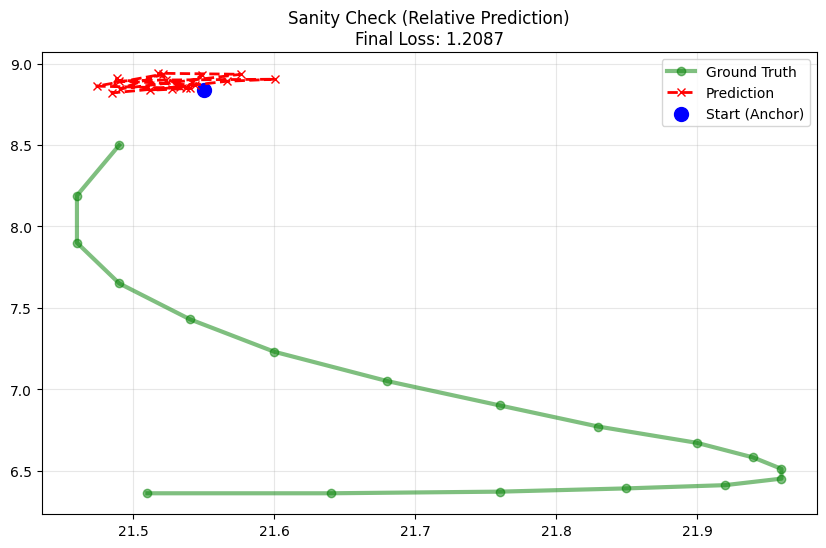

In [76]:
# Sanity Check (Relative Targets)

print("🧪 STARTING SANITY CHECK (Relative Targets)...")

batch = next(iter(train_loader))
input_seq = batch['input_seq'].to(device).float()
output_seq = batch['output_seq'].to(device).float() # Relative targets
anchors = batch['anchors'].to(device).float()
mask = batch['mask'].to(device)
role_ids = batch['role_ids'].to(device)
side_ids = batch['side_ids'].to(device)
players_to_predict = batch['players_to_predict'].to(device)
num_output_frames = batch['num_output_frames']

# Check Features
print("\n🔍 Feature Check:")
print(f"  Input Mean: {input_seq.mean().item():.4f} (Should be ~0)")
print(f"  Input Std:  {input_seq.std().item():.4f} (Should be ~1)")
print(f"  Target Mean: {output_seq.mean().item():.4f} (Should be small, e.g. < 5)")

test_optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
model.train()
losses = []

print(f"\n📉 Training on single batch...")
for i in range(50):
    test_optimizer.zero_grad()
    pred = model(input_seq, role_ids, side_ids, num_output_frames, mask)
    
    loss = 0
    count = 0
    for b in range(pred.shape[0]):
        T = num_output_frames[b]
        pmask = players_to_predict[b]
        if pmask.sum() > 0:
            loss += F.mse_loss(pred[b, pmask, :T, :], output_seq[b, pmask, :T, :])
            count += 1
            
    if count > 0:
        loss = loss / count
        loss.backward()
        test_optimizer.step()
        losses.append(loss.item())
        
    if i % 10 == 0:
        print(f"  Iter {i}: Loss = {loss.item():.6f}")

print(f"  Final Loss: {losses[-1]:.6f}")

# Visualization (Restoring Absolute Coords)
import matplotlib.pyplot as plt
model.eval()
with torch.no_grad():
    pred = model(input_seq, role_ids, side_ids, num_output_frames, mask)

b_idx = 0
# Find first player to predict
ptp = torch.where(players_to_predict[b_idx])[0]
if len(ptp) > 0:
    p_idx = ptp[0].item()
    T = num_output_frames[b_idx]
    
    # Restore absolute
    anchor = anchors[b_idx, p_idx].cpu().numpy()
    pred_traj = pred[b_idx, p_idx, :T, :].cpu().numpy() + anchor
    true_traj = output_seq[b_idx, p_idx, :T, :].cpu().numpy() + anchor
    
    plt.figure(figsize=(10, 6))
    plt.plot(true_traj[:, 0], true_traj[:, 1], 'g-o', label='Ground Truth', linewidth=3, alpha=0.5)
    plt.plot(pred_traj[:, 0], pred_traj[:, 1], 'r--x', label='Prediction', linewidth=2)
    plt.scatter([anchor[0]], [anchor[1]], c='blue', s=100, label='Start (Anchor)')
    plt.title(f"Sanity Check (Relative Prediction)\nFinal Loss: {losses[-1]:.4f}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("No players to predict in this batch sample.")

In [78]:
# Training Loop (Longer Run)

NUM_EPOCHS = 30          # ↑ Increased from 12
LEARNING_RATE = 1e-4     # ↓ Lower LR for stable training with larger model
WEIGHT_DECAY = 1e-3      # ↑ Higher decay to prevent overfitting

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

history = {'train_loss': [], 'val_loss': [], 'lr': []}
best_val_loss = float('inf')
patience_counter = 0
MAX_PATIENCE = 6         # ↑ More patience

print(f"🚀 Starting Training ({NUM_EPOCHS} epochs)")

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\nEpoch {epoch}/{NUM_EPOCHS}")
    
    # These functions now have the .float() fix inside them
    train_loss = train_epoch(model, train_loader, optimizer, device)
    val_loss = validate_epoch(model, val_loader, device)
    
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['lr'].append(current_lr)
    
    print(f"  Train Loss: {train_loss:.6f}")
    print(f"  Val Loss:   {val_loss:.6f}")
    if current_lr < old_lr:
        print(f"  📉 LR reduced: {old_lr:.2e} → {current_lr:.2e}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save({
            'model_state_dict': model.state_dict(),
            'config': model_config,
            'feature_cols': train_dataset.feature_cols,
            'means': train_dataset.means,
            'stds': train_dataset.stds
        }, PROCESSED_DATA_PATH / 'best_model.pth')
        print(f"  ✅ Saved new best model")
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{MAX_PATIENCE})")
    
    if patience_counter >= MAX_PATIENCE:
        print(f"⚠️ Early stopping")
        break
    
    gc.collect()
    if device.type == 'cuda':
        torch.cuda.empty_cache()

print("✅ Training Complete")

🚀 Starting Training (30 epochs)

Epoch 1/30


Validating: 100%|██████████| 102/102 [03:52<00:00,  2.28s/it]


  Train Loss: 11.239027
  Val Loss:   11.465813
  ✅ Saved new best model

Epoch 2/30


Validating: 100%|██████████| 102/102 [03:54<00:00,  2.30s/it]


  Train Loss: 9.775416
  Val Loss:   10.886932
  ✅ Saved new best model

Epoch 3/30


Validating: 100%|██████████| 102/102 [03:54<00:00,  2.30s/it]


  Train Loss: 9.318595
  Val Loss:   10.514861
  ✅ Saved new best model

Epoch 4/30


Validating: 100%|██████████| 102/102 [03:53<00:00,  2.29s/it]


  Train Loss: 9.077487
  Val Loss:   10.434012
  ✅ Saved new best model

Epoch 5/30


Validating: 100%|██████████| 102/102 [03:54<00:00,  2.30s/it]


  Train Loss: 8.926736
  Val Loss:   10.302763
  ✅ Saved new best model

Epoch 6/30


Validating: 100%|██████████| 102/102 [03:56<00:00,  2.32s/it]


  Train Loss: 8.717378
  Val Loss:   10.113035
  ✅ Saved new best model

Epoch 7/30


Validating: 100%|██████████| 102/102 [03:53<00:00,  2.29s/it]


  Train Loss: 8.571596
  Val Loss:   10.121804
  No improvement (1/6)

Epoch 8/30


Validating: 100%|██████████| 102/102 [04:14<00:00,  2.49s/it]


  Train Loss: 8.484854
  Val Loss:   9.886001
  ✅ Saved new best model

Epoch 9/30


Validating: 100%|██████████| 102/102 [03:53<00:00,  2.29s/it]


  Train Loss: 8.341046
  Val Loss:   9.943471
  No improvement (1/6)

Epoch 10/30


Validating: 100%|██████████| 102/102 [03:53<00:00,  2.29s/it]


  Train Loss: 8.197924
  Val Loss:   10.014448
  No improvement (2/6)

Epoch 11/30


Validating: 100%|██████████| 102/102 [03:54<00:00,  2.30s/it]


  Train Loss: 8.145381
  Val Loss:   9.797431
  ✅ Saved new best model

Epoch 12/30


Validating: 100%|██████████| 102/102 [03:53<00:00,  2.29s/it]


  Train Loss: 8.062843
  Val Loss:   9.895766
  No improvement (1/6)

Epoch 13/30


Validating: 100%|██████████| 102/102 [03:55<00:00,  2.30s/it]


  Train Loss: 7.995768
  Val Loss:   9.727702
  ✅ Saved new best model

Epoch 14/30


Validating: 100%|██████████| 102/102 [03:54<00:00,  2.30s/it]


  Train Loss: 7.844780
  Val Loss:   9.756842
  No improvement (1/6)

Epoch 15/30


Validating: 100%|██████████| 102/102 [03:55<00:00,  2.31s/it]


  Train Loss: 7.777650
  Val Loss:   9.880637
  No improvement (2/6)

Epoch 16/30


Validating: 100%|██████████| 102/102 [03:53<00:00,  2.28s/it]


  Train Loss: 7.710656
  Val Loss:   9.598905
  ✅ Saved new best model

Epoch 17/30


Validating: 100%|██████████| 102/102 [03:53<00:00,  2.29s/it]


  Train Loss: 7.632089
  Val Loss:   9.672073
  No improvement (1/6)

Epoch 18/30


Validating: 100%|██████████| 102/102 [03:54<00:00,  2.30s/it]


  Train Loss: 7.553834
  Val Loss:   9.787444
  No improvement (2/6)

Epoch 19/30


Validating: 100%|██████████| 102/102 [03:53<00:00,  2.29s/it]


  Train Loss: 7.502950
  Val Loss:   9.937069
  No improvement (3/6)

Epoch 20/30


Validating: 100%|██████████| 102/102 [03:53<00:00,  2.29s/it]


  Train Loss: 7.400178
  Val Loss:   9.727542
  📉 LR reduced: 1.00e-04 → 5.00e-05
  No improvement (4/6)

Epoch 21/30


Validating: 100%|██████████| 102/102 [03:54<00:00,  2.30s/it]


  Train Loss: 7.107460
  Val Loss:   9.619688
  No improvement (5/6)

Epoch 22/30


Validating: 100%|██████████| 102/102 [03:54<00:00,  2.30s/it]

  Train Loss: 7.043368
  Val Loss:   9.695813
  No improvement (6/6)
⚠️ Early stopping
✅ Training Complete


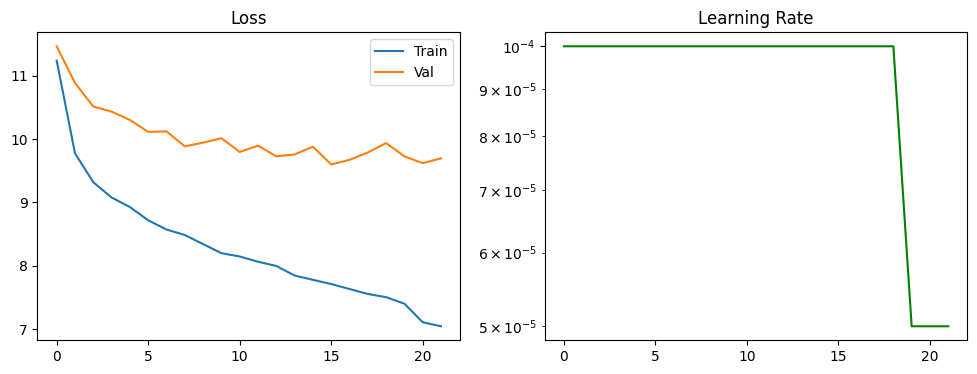

In [79]:
# Plot History
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Val')
axes[0].set_title('Loss')
axes[0].legend()
axes[1].plot(history['lr'], color='green')
axes[1].set_title('Learning Rate')
axes[1].set_yscale('log')
plt.show()

In [80]:
# Evaluation Metrics (Updated for Relative Targets)

def compute_metrics(model, loader, device):
    """Compute ADE and FDE metrics (restoring absolute coordinates)"""
    model.eval()
    all_ade = []
    all_fde = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Computing metrics"):
            input_seq = batch['input_seq'].to(device).float()
            output_seq = batch['output_seq'].to(device).float() # Relative
            anchors = batch['anchors'].to(device).float()       # Absolute start
            mask = batch['mask'].to(device)
            role_ids = batch['role_ids'].to(device)
            side_ids = batch['side_ids'].to(device)
            players_to_predict = batch['players_to_predict']
            num_output_frames = batch['num_output_frames']
            
            # Predict (Relative)
            pred_rel = model(input_seq, role_ids, side_ids, num_output_frames, mask)
            
            for b in range(pred_rel.shape[0]):
                T = num_output_frames[b]
                pmask = players_to_predict[b]
                
                if pmask.sum() == 0: continue
                
                # Get relative preds and targets
                pred_b_rel = pred_rel[b, pmask, :T, :]
                target_b_rel = output_seq[b, pmask, :T, :]
                
                # Restore Absolute Coordinates for Metric Calculation
                # Anchor shape: (P, 2) -> (P_masked, 1, 2)
                anchor_b = anchors[b, pmask, :].unsqueeze(1)
                
                pred_b_abs = pred_b_rel + anchor_b
                target_b_abs = target_b_rel + anchor_b
                
                # Displacement errors
                displacements = torch.sqrt(((pred_b_abs - target_b_abs) ** 2).sum(dim=-1))
                
                all_ade.append(displacements.mean().item())
                all_fde.append(displacements[:, -1].mean().item())
    
    return {
        'ADE_mean': np.mean(all_ade),
        'ADE_std': np.std(all_ade),
        'FDE_mean': np.mean(all_fde),
        'FDE_std': np.std(all_fde),
    }

🎨 Creating visualizations...


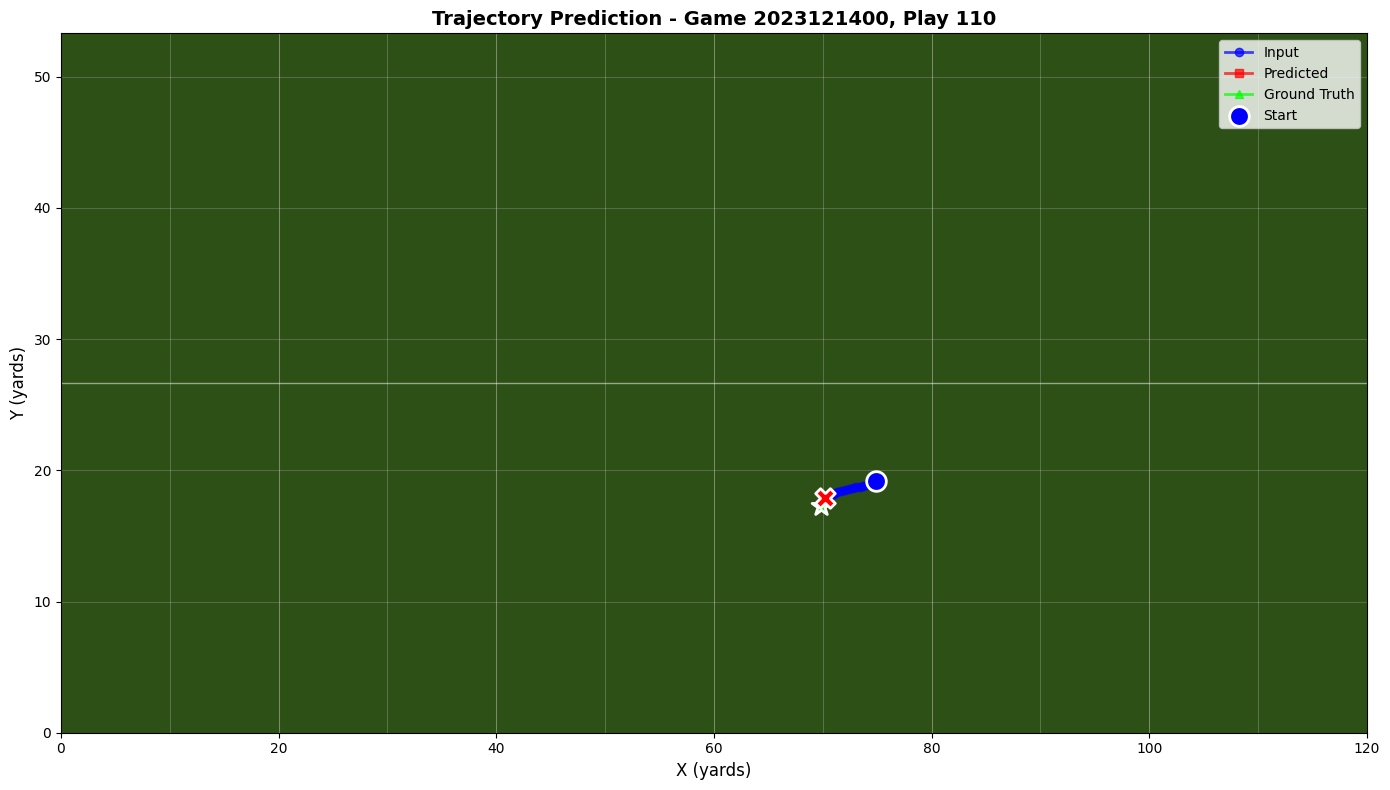

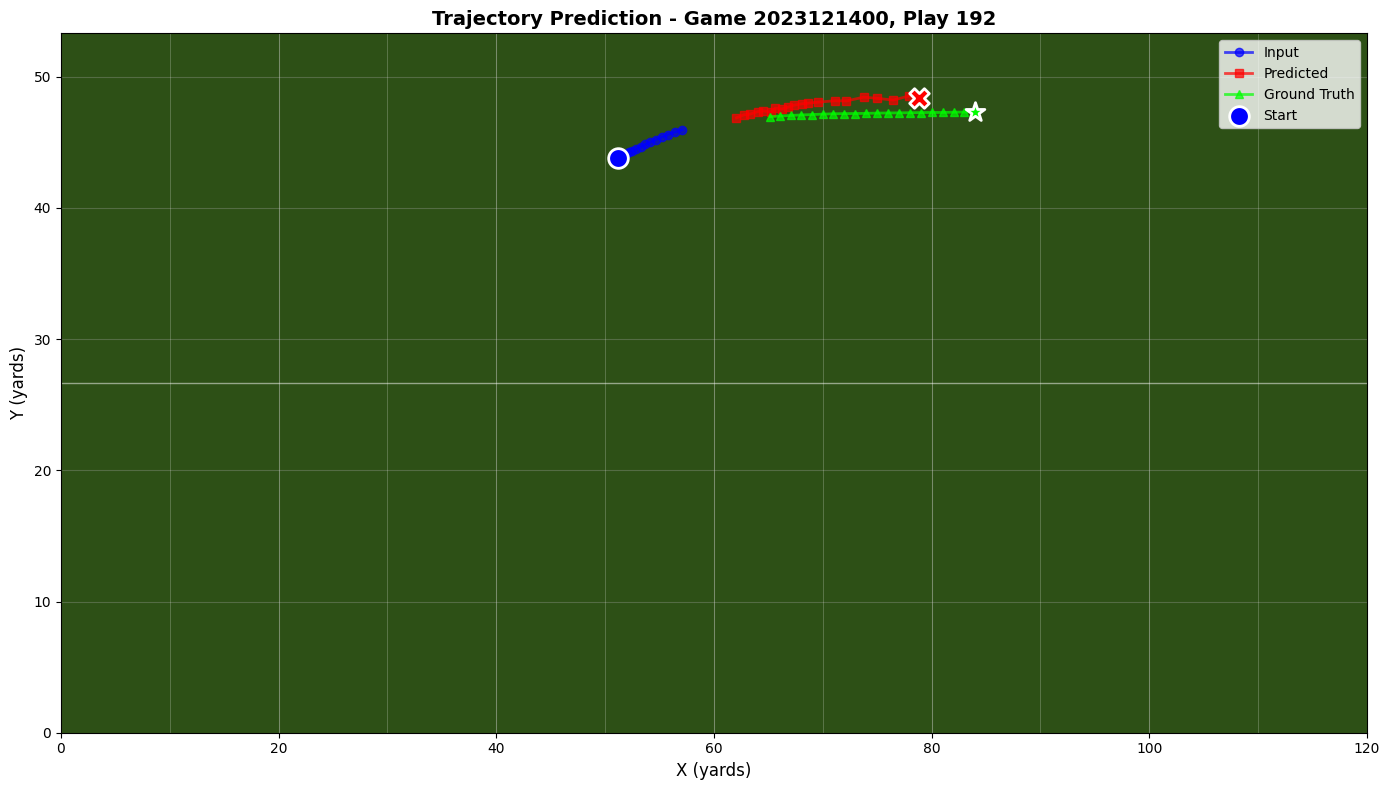

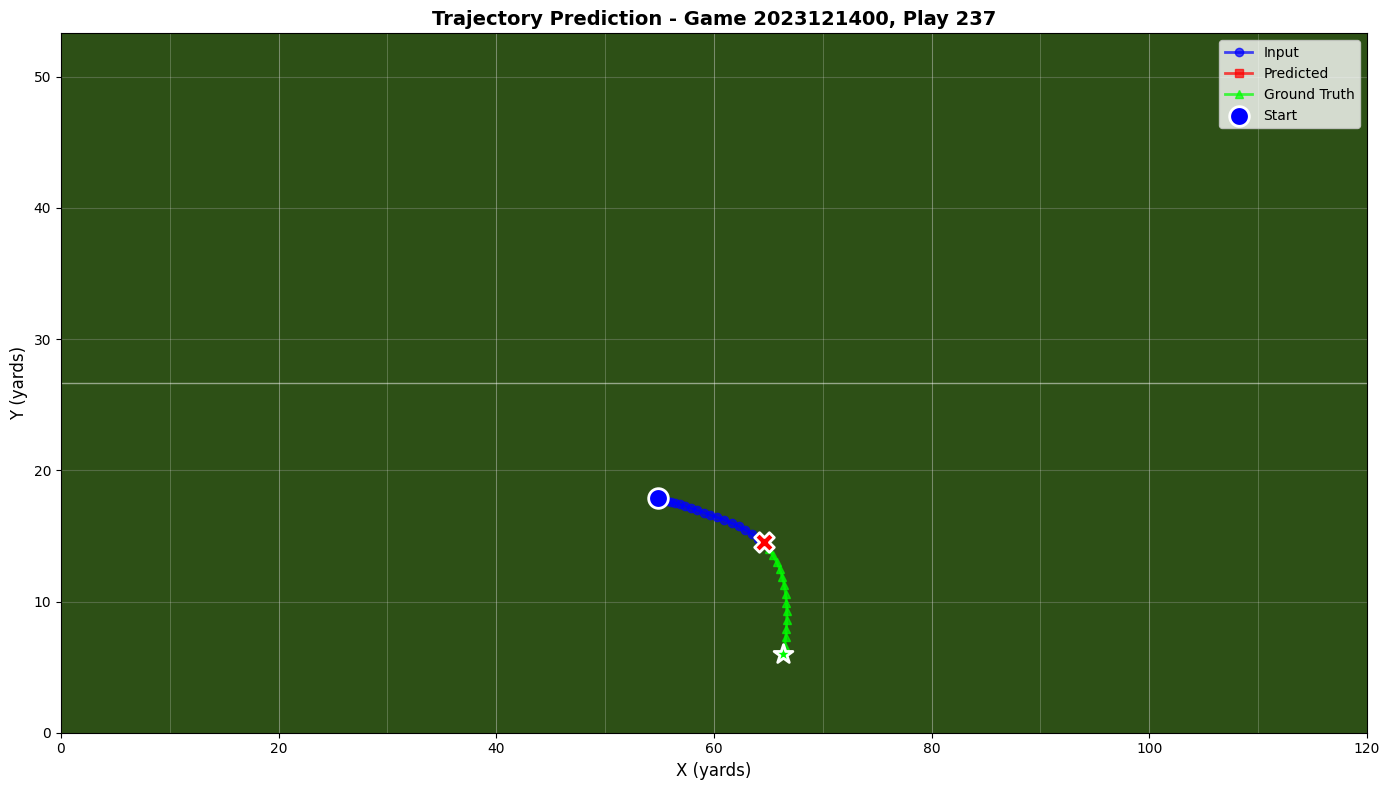

✅ Visualizations saved to ..\data\processed


In [81]:
# Visualize Sample Predictions (Fixed for Relative Targets)

def visualize_prediction(model, dataset, idx, device):
    """Visualize a single prediction with Relative Targets restored to Absolute"""
    model.eval()
    
    sample = dataset[idx]
    
    # Prepare batch of 1
    input_seq = sample['input_seq'].unsqueeze(0).to(device).float()
    output_seq = sample['output_seq'].unsqueeze(0).float() # Relative
    anchors = sample['anchors'].unsqueeze(0).float()       # Absolute
    mask = sample['mask'].unsqueeze(0).to(device)
    role_ids = sample['role_ids'].unsqueeze(0).to(device)
    side_ids = sample['side_ids'].unsqueeze(0).to(device)
    players_to_predict = sample['players_to_predict'] # 1D tensor
    num_output_frames = [sample['num_output_frames']]
    metadata = sample['metadata']
    
    with torch.no_grad():
        pred_rel = model(input_seq, role_ids, side_ids, num_output_frames, mask)
        pred_rel = pred_rel.cpu()
    
    # Find a player to predict
    ptp_indices = torch.where(players_to_predict)[0]
    if len(ptp_indices) == 0:
        print("No players to predict in this sample")
        return None
    
    player_idx = ptp_indices[0].item()
    T = num_output_frames[0]
    
    # Restore Absolute Coordinates
    anchor = anchors[0, player_idx].numpy() # (2,)
    
    # Get trajectories (Relative -> Absolute)
    pred_traj = pred_rel[0, player_idx, :T, :].numpy() + anchor
    target_traj = output_seq[0, player_idx, :T, :].numpy() + anchor
    
    # Denormalize input for visualization
    input_data = sample['input_seq'][:, player_idx, :].numpy()
    means = dataset.means
    stds = dataset.stds
    input_denorm = input_data * stds + means
    
    # Plot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Field boundaries
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 53.3)
    ax.set_facecolor('#2d5016')
    
    # Field lines
    for x in range(0, 121, 10):
        ax.axvline(x, color='white', linewidth=0.5, alpha=0.3)
    ax.axhline(53.3/2, color='white', linewidth=1, alpha=0.5)
    
    # Input trajectory (x, y are first two features)
    valid_frames = ~sample['mask'][:, player_idx].numpy()
    input_x = input_denorm[valid_frames, 0]
    input_y = input_denorm[valid_frames, 1]
    ax.plot(input_x, input_y, 'o-', color='blue', linewidth=2, 
            markersize=6, label='Input', alpha=0.7)
    
    # Predicted trajectory
    ax.plot(pred_traj[:, 0], pred_traj[:, 1], 's-', color='red', 
            linewidth=2, markersize=6, label='Predicted', alpha=0.7)
    
    # Ground truth trajectory
    ax.plot(target_traj[:, 0], target_traj[:, 1], '^-', color='lime', 
            linewidth=2, markersize=6, label='Ground Truth', alpha=0.7)
    
    # Start/end markers
    if len(input_x) > 0:
        ax.scatter(input_x[0], input_y[0], s=200, c='blue', marker='o', 
                   edgecolors='white', linewidths=2, zorder=5, label='Start')
    ax.scatter(target_traj[-1, 0], target_traj[-1, 1], s=200, c='lime', 
               marker='*', edgecolors='white', linewidths=2, zorder=5)
    ax.scatter(pred_traj[-1, 0], pred_traj[-1, 1], s=200, c='red', 
               marker='X', edgecolors='white', linewidths=2, zorder=5)
    
    ax.set_xlabel('X (yards)', fontsize=12)
    ax.set_ylabel('Y (yards)', fontsize=12)
    ax.set_title(f"Trajectory Prediction - Game {metadata['game_id']}, Play {metadata['play_id']}", 
                 fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Visualize a few samples
print("🎨 Creating visualizations...")

for i in range(min(3, len(val_dataset))):
    fig = visualize_prediction(model, val_dataset, i, device)
    if fig:
        fig.savefig(PROCESSED_DATA_PATH / f'prediction_sample_{i}.png', dpi=150, bbox_inches='tight')
        plt.show()
        plt.close(fig)

print(f"✅ Visualizations saved to {PROCESSED_DATA_PATH}")

In [82]:
# Save Final Artifacts (Robust Version)

# Ensure metrics exist before saving
if 'metrics' not in locals():
    print("⚠️ Metrics not found. Computing them now...")
    # Load best model first to get accurate metrics
    if (PROCESSED_DATA_PATH / 'best_model.pth').exists():
        checkpoint = torch.load(PROCESSED_DATA_PATH / 'best_model.pth')
        model.load_state_dict(checkpoint['model_state_dict'])
        print("  Loaded best model weights.")
    
    metrics = compute_metrics(model, val_loader, device)
    print(f"  ADE: {metrics['ADE_mean']:.4f}, FDE: {metrics['FDE_mean']:.4f}")

# Save final model with all metadata
final_save_path = PROCESSED_DATA_PATH / 'final_model_complete.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'config': model_config,
    'feature_cols': train_dataset.feature_cols,
    'feature_means': train_dataset.means.tolist(), # Use .means directly (numpy array)
    'feature_stds': train_dataset.stds.tolist(),   # Use .stds directly
    'history': history,
    'metrics': metrics,
    'train_weeks': TRAIN_WEEKS,
    'val_weeks': VAL_WEEKS,
}, final_save_path)

# Save training history
with open(PROCESSED_DATA_PATH / 'training_history.json', 'w') as f:
    json.dump(history, f, indent=2)

# Save metrics
with open(PROCESSED_DATA_PATH / 'evaluation_metrics.json', 'w') as f:
    # Convert numpy types to python float for JSON serialization
    metrics_json = {k: float(v) for k, v in metrics.items()}
    json.dump(metrics_json, f, indent=2)

# Save normalization stats
norm_stats = {
    'feature_cols': train_dataset.feature_cols,
    'feature_means': train_dataset.means.tolist(),
    'feature_stds': train_dataset.stds.tolist(),
}
with open(PROCESSED_DATA_PATH / 'normalization_stats.json', 'w') as f:
    json.dump(norm_stats, f, indent=2)

print(f"\n{'='*60}")
print("✅ ALL ARTIFACTS SAVED")
print(f"{'='*60}")
print(f"\n📁 Saved to {PROCESSED_DATA_PATH}:")
print(f"  - final_model_complete.pth")
print(f"  - best_model.pth")
print(f"  - training_history.json")
print(f"  - evaluation_metrics.json")
print(f"  - normalization_stats.json")
print(f"  - prediction_sample_*.png")
print(f"\n{'='*60}")
print("🎉 Modeling notebook complete!")
print(f"{'='*60}")

⚠️ Metrics not found. Computing them now...


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray._reconstruct was not an allowed global by default. Please use `torch.serialization.add_safe_globals([numpy._core.multiarray._reconstruct])` or the `torch.serialization.safe_globals([numpy._core.multiarray._reconstruct])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.